In [ ]:
# add a comment for the sake of it
# and another

In [44]:
import pandas as pd
import numpy as np
import torch

from sklearn.preprocessing import StandardScaler  # for feature scaling
from sklearn.model_selection import train_test_split  # for train/test split

from scipy import stats


In [45]:
df = pd.read_csv('C:/Users/dgwal/jup_notebook/tennis.csv')
df.head()

,Unnamed: 0,flag,rolling_rank_diff,rolling_rank points_diff,rolling_ace_per_svpt_diff,rolling_df_per_svpt_diff,rolling_1stIn_per_svpt_diff,rolling_1stWon_per_svpt_diff,rolling_2ndWon_per_svpt_diff,rolling_bpSaved_per_svpt_diff,rolling_bpFaced_per_svpt_diff,rolling_bpSaved_per_bpFaced_diff,Elo_diff
0,0,0,-34.90000,760.50000,0.01423,0.01371,0.07728,0.08082,-0.05444,-0.02077,-0.01596,-0.27333,-57.200022
1,1,1,-20.41667,1321.25000,0.02177,-0.02151,0.05423,0.04467,-0.02390,0.00738,0.00139,0.14623,10.575487
2,2,0,-3.12821,425.25641,0.02513,-0.01549,0.00616,-0.00185,0.00823,0.00175,-0.00033,0.03552,-21.381048
3,3,1,-8.61538,53.00000,-0.00196,0.00438,0.01586,0.02335,-0.01013,-0.00763,-0.00764,-0.10385,9.736601
4,4,0,9.90909,84.81818,0.02491,-0.00310,-0.02679,-0.00749,0.02392,-0.00412,-0.00722,-0.02693,-29.959924


In [46]:
#df.sort_values('rolling_1stIn_per_svpt_diff')
#df.head(20)
mask = ~df.isnull().any(axis=1)
df = df[mask]

# remove outliers (arbitrary z score of 7)
df = df[(np.abs(stats.zscore(df)) < 7).all(axis=1)]



In [47]:
X = df.iloc[:, 2:].to_numpy()
y = df.iloc[:, 1].to_numpy()

print(f"First 4 X features:\n{X[:4]}")
print(f"\nFirst 4 y labels:\n{y[:4]}")

First 4 X features:
[[-3.49000000e+01  7.60500000e+02  1.42300000e-02  1.37100000e-02
   7.72800000e-02  8.08200000e-02 -5.44400000e-02 -2.07700000e-02
  -1.59600000e-02 -2.73330000e-01 -5.72000221e+01]
 [-2.04166700e+01  1.32125000e+03  2.17700000e-02 -2.15100000e-02
   5.42300000e-02  4.46700000e-02 -2.39000000e-02  7.38000000e-03
   1.39000000e-03  1.46230000e-01  1.05754874e+01]
 [-3.12821000e+00  4.25256410e+02  2.51300000e-02 -1.54900000e-02
   6.16000000e-03 -1.85000000e-03  8.23000000e-03  1.75000000e-03
  -3.30000000e-04  3.55200000e-02 -2.13810476e+01]
 [-8.61538000e+00  5.30000000e+01 -1.96000000e-03  4.38000000e-03
   1.58600000e-02  2.33500000e-02 -1.01300000e-02 -7.63000000e-03
  -7.64000000e-03 -1.03850000e-01  9.73660055e+00]]

First 4 y labels:
[0 1 0 1]


In [48]:
sc = StandardScaler()
X = sc.fit_transform(X)
#X_test = sc.transform(X_test)


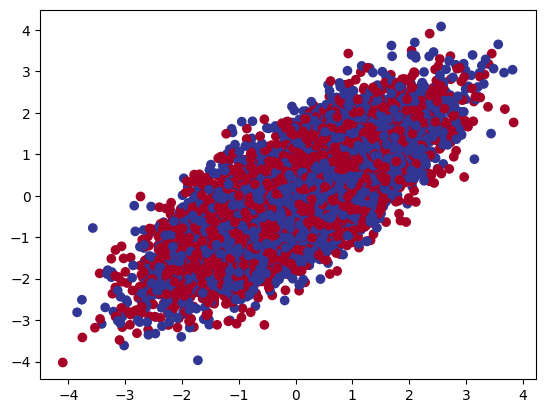

In [49]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 4], 
            y=X[:, 5], 
            c=y, 
            cmap=plt.cm.RdYlBu);

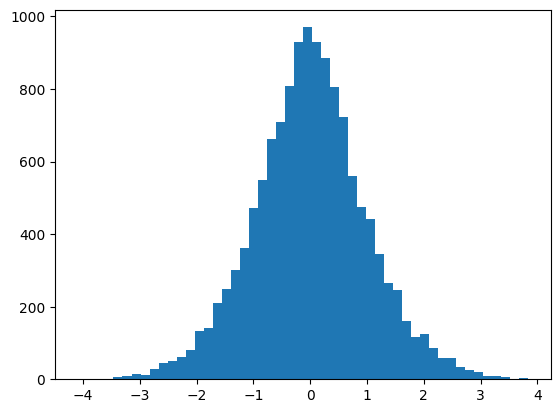

In [50]:
plt.hist(X[:, 4], bins = 50);

In [51]:
# Check the shapes of our features and labels
X.shape, y.shape

((13200, 11), (13200,))

In [52]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [-1.2485753   0.68914042  0.6641973   1.74842507  3.45466198  3.42615069
 -3.73432749 -2.53698121 -1.30099237 -4.98496343 -0.37423963] and the same for y: 0
Shapes for one sample of X: (11,) and the same for y: ()


In [53]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[-1.2486,  0.6891,  0.6642,  1.7484,  3.4547,  3.4262, -3.7343, -2.5370,
          -1.3010, -4.9850, -0.3742],
         [-0.7344,  1.2001,  1.0121, -2.7319,  2.4207,  1.8936, -1.6242,  0.8716,
           0.0900,  2.6438,  0.0590],
         [-0.1206,  0.3837,  1.1672, -1.9661,  0.2644, -0.0786,  0.5958,  0.1899,
          -0.0479,  0.6308, -0.1453],
         [-0.3154,  0.0444, -0.0829,  0.5616,  0.6995,  0.9898, -0.6728, -0.9459,
          -0.6340, -1.9033,  0.0536],
         [ 0.3422,  0.0734,  1.1570, -0.3900, -1.2137, -0.3177,  1.6799, -0.5209,
          -0.6003, -0.5047, -0.2001]]),
 tensor([0., 1., 0., 1., 0.]))

In [54]:
# Split data into train and test sets - chronological data so this is a bit meh but let's go with it for now...
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(10560, 2640, 10560, 2640)

In [55]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [56]:
X.shape[1]

11

In [57]:
# 1. Construct a model class that subclasses nn.Module
class TennisModel1(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=X.shape[1], out_features=5) # takes features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = TennisModel1().to(device)
model_0

TennisModel1(
  (layer_1): Linear(in_features=11, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [58]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=X.shape[1], out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0


Sequential(
  (0): Linear(in_features=11, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [59]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 2640, Shape: torch.Size([2640, 1])
Length of test samples: 2640, Shape: torch.Size([2640])

First 10 predictions:
tensor([[ 0.1558],
        [-0.0051],
        [ 0.0132],
        [-0.0324],
        [ 0.2144],
        [ 0.0292],
        [-0.0830],
        [-0.0887],
        [ 0.0466],
        [-0.1855]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 1.])


In [60]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [61]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [62]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.1558],
        [-0.0051],
        [ 0.0132],
        [-0.0324],
        [ 0.2144]], grad_fn=<SliceBackward0>)

In [63]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5389],
        [0.4987],
        [0.5033],
        [0.4919],
        [0.5534]], grad_fn=<SigmoidBackward0>)

In [64]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 0., 1., 0., 1.], grad_fn=<SqueezeBackward0>)

In [65]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.67432, Accuracy: 60.14% | Test loss: 0.67171, Test acc: 59.58%


Epoch: 10 | Loss: 0.64513, Accuracy: 67.52% | Test loss: 0.64210, Test acc: 68.56%
Epoch: 20 | Loss: 0.62115, Accuracy: 70.01% | Test loss: 0.61807, Test acc: 71.89%
Epoch: 30 | Loss: 0.60041, Accuracy: 71.37% | Test loss: 0.59790, Test acc: 73.33%
Epoch: 40 | Loss: 0.58344, Accuracy: 72.28% | Test loss: 0.58192, Test acc: 73.98%
Epoch: 50 | Loss: 0.57052, Accuracy: 73.00% | Test loss: 0.57017, Test acc: 74.32%
Epoch: 60 | Loss: 0.56124, Accuracy: 73.31% | Test loss: 0.56205, Test acc: 74.39%
Epoch: 70 | Loss: 0.55485, Accuracy: 73.52% | Test loss: 0.55671, Test acc: 74.43%
Epoch: 80 | Loss: 0.55057, Accuracy: 73.49% | Test loss: 0.55333, Test acc: 74.39%
Epoch: 90 | Loss: 0.54775, Accuracy: 73.62% | Test loss: 0.55128, Test acc: 74.28%


In [66]:
class TennisModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=X.shape[1], out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = TennisModel2().to(device)
model_1

TennisModel2(
  (layer_1): Linear(in_features=11, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [67]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [68]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70875, Accuracy: 50.65% | Test loss: 0.70463, Test acc: 50.53%
Epoch: 100 | Loss: 0.54862, Accuracy: 73.38% | Test loss: 0.55137, Test acc: 74.17%
Epoch: 200 | Loss: 0.54285, Accuracy: 73.58% | Test loss: 0.54936, Test acc: 74.24%
Epoch: 300 | Loss: 0.54264, Accuracy: 73.64% | Test loss: 0.54949, Test acc: 74.05%
Epoch: 400 | Loss: 0.54255, Accuracy: 73.63% | Test loss: 0.54951, Test acc: 74.13%
Epoch: 500 | Loss: 0.54250, Accuracy: 73.65% | Test loss: 0.54954, Test acc: 73.98%
Epoch: 600 | Loss: 0.54247, Accuracy: 73.65% | Test loss: 0.54956, Test acc: 73.90%
Epoch: 700 | Loss: 0.54246, Accuracy: 73.66% | Test loss: 0.54958, Test acc: 73.94%
Epoch: 800 | Loss: 0.54245, Accuracy: 73.66% | Test loss: 0.54959, Test acc: 73.94%
Epoch: 900 | Loss: 0.54244, Accuracy: 73.65% | Test loss: 0.54960, Test acc: 73.83%


In [69]:
# Build model with non-linear activation function
from torch import nn
class TennisModel3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=X.shape[1], out_features=20)
        self.layer_2 = nn.Linear(in_features=20, out_features=30)
        self.layer_3 = nn.Linear(in_features=30, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = TennisModel3().to(device)
print(model_3)

TennisModel3(
  (layer_1): Linear(in_features=11, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=30, bias=True)
  (layer_3): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
)


In [70]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [71]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69627, Accuracy: 50.67% | Test Loss: 0.69737, Test Accuracy: 50.11%
Epoch: 100 | Loss: 0.65691, Accuracy: 67.29% | Test Loss: 0.65599, Test Accuracy: 67.42%
Epoch: 200 | Loss: 0.56461, Accuracy: 71.46% | Test Loss: 0.56566, Test Accuracy: 72.42%
Epoch: 300 | Loss: 0.54558, Accuracy: 73.10% | Test Loss: 0.54974, Test Accuracy: 73.37%
Epoch: 400 | Loss: 0.54230, Accuracy: 73.43% | Test Loss: 0.54750, Test Accuracy: 73.41%
Epoch: 500 | Loss: 0.54067, Accuracy: 73.43% | Test Loss: 0.54607, Test Accuracy: 73.48%
Epoch: 600 | Loss: 0.53974, Accuracy: 73.49% | Test Loss: 0.54521, Test Accuracy: 73.52%
Epoch: 700 | Loss: 0.53903, Accuracy: 73.61% | Test Loss: 0.54453, Test Accuracy: 73.71%
Epoch: 800 | Loss: 0.53846, Accuracy: 73.70% | Test Loss: 0.54424, Test Accuracy: 73.98%
Epoch: 900 | Loss: 0.53803, Accuracy: 73.80% | Test Loss: 0.54410, Test Accuracy: 74.05%


In [1]:
import captum

In [3]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [74]:
ig = IntegratedGradients(model_3)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model_3)
gs = GradientShap(model_3)
fa = FeatureAblation(model_3)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

NameError: name 'NoiseTunnel' is not defined